In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
train.shape

(90275, 3)

In [3]:
# remove the outliers

ulimit = np.percentile(train.logerror.values, 99)
llimit = np.percentile(train.logerror.values, 1)
train['logerror'].ix[train['logerror']>ulimit] = ulimit
train['logerror'].ix[train['logerror']<llimit] = llimit

C:\software_program\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
C:\software_program\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [4]:
props= pd.read_csv("../input/properties_2016.csv")
props.shape

C:\software_program\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [5]:
# merge two datasets
for c, dtype in zip(props.columns, props.dtypes):
    if dtype == np.float64:
        props[c] = props[c].astype(np.float32)

df_train = train.merge(props, how='left', on='parcelid')
del props, train
df_train = df_train.drop(['parcelid', 'transactiondate'], axis=1)

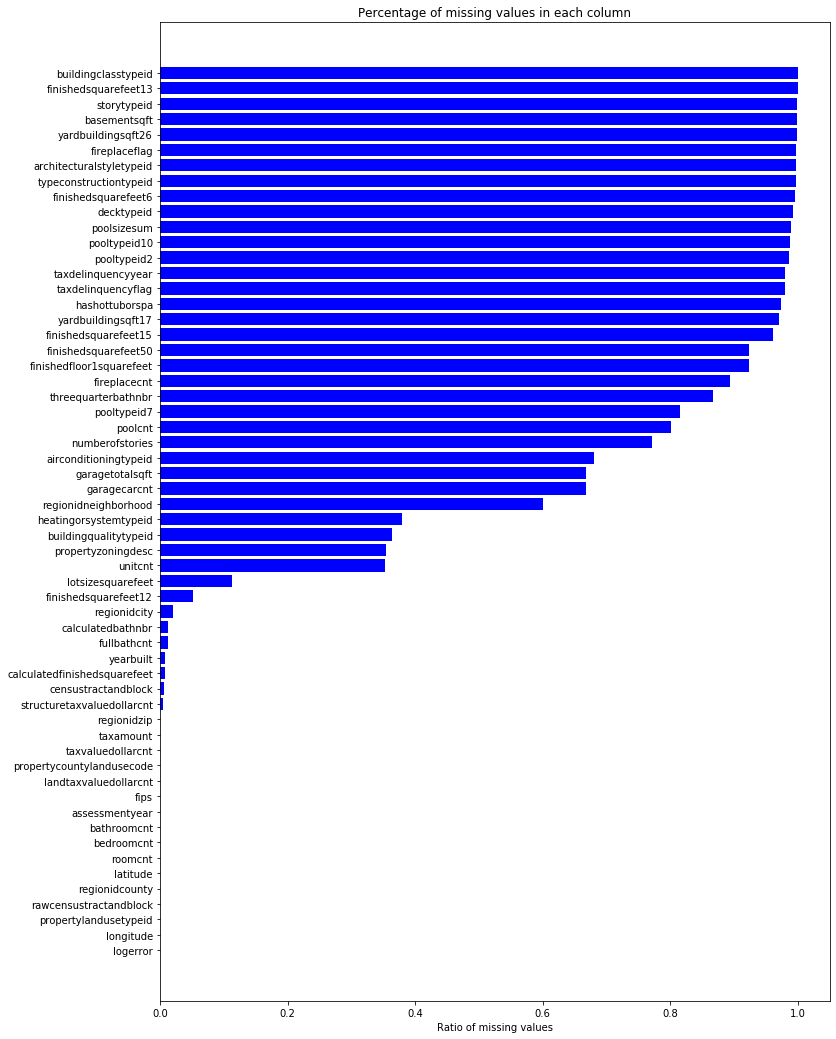

In [7]:
missing_df = props.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / props.shape[0]
missing_df = missing_df.sort_values(by='missing_ratio')
# missing_df.ix[missing_df['missing_ratio']>0.6]

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_ratio.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Percentage of missing values in each column")
plt.show()

In [8]:
dropcols = []

In [9]:
#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = props.hashottuborspa.isnull()
#print(index)
props.loc[index,'hashottuborspa'] = "FALSE"

# pooltypeid10(does home have a Spa or hot tub) seems to be inconcistent with the 'hashottuborspa' field
print(props.hashottuborspa.value_counts())
print(props.pooltypeid10.value_counts())

#lets remove 'pooltypeid10' as has more missing values
dropcols.append('pooltypeid10')

#Assume if the pooltype id is null then pool/hottub doesnt exist 
index = props.pooltypeid2.isnull()
props.loc[index,'pooltypeid2'] = 0

index = props.pooltypeid7.isnull()
props.loc[index,'pooltypeid7'] = 0

index = props.poolcnt.isnull()
props.loc[index,'poolcnt'] = 0

FALSE    87910
True      2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64


In [10]:
#Theres more missing values in the 'poolsizesum' then in 'poolcnt', 
#Let's fill in median values for poolsizesum where pool count is >0 and missing. 
#This is sensible assumption as residential pool sizes are fairly standard size in the U.S.
#Also the poolsizesum doesn't seem to be much of an important variable so imputing with the median
print(props.poolsizesum.isnull().sum())
print(props.poolcnt.value_counts())

#Fill in those properties that have a pool with median pool value
poolsizesum_median = props.loc[props['poolcnt'] > 0, 'poolsizesum'].median()
props.loc[(props['poolcnt'] > 0) & (props['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
props.loc[(props['poolcnt'] == 0), 'poolsizesum'] = 0

89306
0.0    72374
1.0    17901
Name: poolcnt, dtype: int64


In [11]:
#There should be a one-to-one correspondence between these two items
print(props.fireplaceflag.isnull().sum())
print(props.fireplacecnt.isnull().sum())

90053
80668


In [12]:
#There seems to be 80668 properties without fireplace according to the 'fireplacecnt' but the 'fireplace flag' says they are 90053 missing values
#Lets instead create the fireplaceflag from scratch using 'fireplacecnt' as there are less missing values here
props['fireplaceflag']= "FALSE"
props.loc[props['fireplacecnt']>0,'fireplaceflag']= "TRUE"

index = props.fireplacecnt.isnull()
props.loc[index,'fireplacecnt'] = 0

#Tax deliquency flag - assume if it is null then doesn't exist
index = props.taxdelinquencyflag.isnull()
props.loc[index,'taxdelinquencyflag'] = "N"

In [13]:
#Same number of missing values between garage count and garage size - assume this is because when there are properties with no garages then both variables are NA
print(props.garagecarcnt.isnull().sum())
print(props.garagetotalsqft.isnull().sum())

#Assume if Null in garage count it means there are no garages
index = props.garagecarcnt.isnull()
props.loc[index,'garagecarcnt'] = 0

#Likewise no garage means the size is 0 by default
index = props.garagetotalsqft.isnull()
props.loc[index,'garagetotalsqft'] = 0

#Let's fill in some missing values using the most common value for those variables where this might be a sensible approach
#AC Type - Mostly 1's, which corresponds to central AC. Reasonable to assume most other properties are similar.
props['airconditioningtypeid'].value_counts()
index = props.airconditioningtypeid.isnull()
props.loc[index,'airconditioningtypeid'] = 1

60338
60338


In [14]:
#heating or system - Mostly 2, which corresponds to central heating 
#so seems reasonable to assume most other properties have central heating  
print(props['heatingorsystemtypeid'].value_counts())
index = props.heatingorsystemtypeid.isnull()
props.loc[index,'heatingorsystemtypeid'] = 2

2.0     38303
7.0     15519
24.0     1071
6.0       970
20.0       97
13.0       76
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64


In [15]:
print(props['threequarterbathnbr'].value_counts())
index = props.threequarterbathnbr.isnull()
props.loc[index,'threequarterbathnbr'] = 1

1.0    11912
2.0       90
3.0        6
4.0        1
Name: threequarterbathnbr, dtype: int64


In [18]:
missingvaluescols

['buildingclasstypeid',
 'finishedsquarefeet13',
 'basementsqft',
 'storytypeid',
 'yardbuildingsqft26',
 'architecturalstyletypeid',
 'typeconstructiontypeid',
 'finishedsquarefeet6',
 'decktypeid',
 'pooltypeid10',
 'taxdelinquencyyear',
 'yardbuildingsqft17',
 'finishedsquarefeet15',
 'finishedfloor1squarefeet',
 'finishedsquarefeet50']

In [17]:
dropcols

['pooltypeid10']

In [16]:
missingvalues_prop = (props.isnull().sum()/len(props)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)
missingvaluescols = missingvalues_prop[missingvalues_prop['proportion'] > 0.90].field.tolist()
dropcols_2 = dropcols + missingvaluescols
props = props.drop(dropcols_2, axis=1)

                           field  proportion
6            buildingclasstypeid    0.999823
13          finishedsquarefeet13    0.999634
3                   basementsqft    0.999524
41                   storytypeid    0.999524
46            yardbuildingsqft26    0.998948
2       architecturalstyletypeid    0.997109
43        typeconstructiontypeid    0.996688
16           finishedsquarefeet6    0.995336
9                     decktypeid    0.992711
29                  pooltypeid10    0.987139
56            taxdelinquencyyear    0.980249
45            yardbuildingsqft17    0.970690
14          finishedsquarefeet15    0.960521
10      finishedfloor1squarefeet    0.924054
15          finishedsquarefeet50    0.924054
48               numberofstories    0.772141
38          regionidneighborhood    0.601086
7          buildingqualitytypeid    0.364564
34            propertyzoningdesc    0.354052
44                       unitcnt    0.353608
26             lotsizesquarefeet    0.112434
12        

In [34]:
df_train.isnull().sum()

logerror                            0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           32911
calculatedbathnbr                1182
calculatedfinishedsquarefeet      661
finishedsquarefeet12             4679
fips                                0
fireplacecnt                        0
fullbathcnt                      1182
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               0
latitude                            0
longitude                           0
lotsizesquarefeet               10150
poolcnt                             0
poolsizesum                         0
pooltypeid2                         0
pooltypeid7                         0
propertycountylandusecode           1
propertylandusetypeid               0
propertyzoningdesc              31962
rawcensustractandblock              0
regionidcity

In [ ]:
buildingqualitytypeid  
propertyzoningdesc 
regionidneighborhood  
unitcnt
numberofstories 

In [35]:
dropcols

['pooltypeid10',
 'pooltypeid10',
 'buildingclasstypeid',
 'finishedsquarefeet13',
 'basementsqft',
 'storytypeid',
 'yardbuildingsqft26',
 'architecturalstyletypeid',
 'typeconstructiontypeid',
 'finishedsquarefeet6',
 'decktypeid',
 'pooltypeid10',
 'taxdelinquencyyear',
 'yardbuildingsqft17',
 'finishedsquarefeet15',
 'finishedfloor1squarefeet',
 'finishedsquarefeet50']

In [36]:
missingvalues_prop.columns

Index(['field', 'proportion'], dtype='object')